<a href="https://colab.research.google.com/github/cpratham3/LSTM_Neural_Network/blob/pratham/Market_Forecast_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
# STEP 1: Install the libraries (if not existing already) [already installed for me]

# !pip install yfinance pandas numpy matplotlib scikit-learn

In [142]:
# STEP 2: Importing the libraries

import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.style.use('seaborn-v0_8-darkgrid')

In [143]:
# STEP 3: Fetch stock data

# We can choose any company that we want the data for.
# The ticker should be accurate.
# Can be found from "https://ca.finance.yahoo.com"
ticker = 'TSLA'   # Tesla

# Download historical data (daily prices)
# Took data from Jan 2020 to Oct 2025
data = yf.download(ticker, start='2025-01-01', end='2025-10-01', auto_adjust=True)

# Flatten column names to a single level for easier access
data.columns = data.columns.droplevel(1)

# Show first few rows for verification
print("Dataset shape:", data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed

Dataset shape: (186, 5)


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,379.279999,392.730011,373.040009,390.100006,109710700
2025-01-03,410.440002,411.880005,379.450012,381.480011,95423300
2025-01-06,411.049988,426.429993,401.700012,423.200012,85516500
2025-01-07,394.359985,414.329987,390.000000,405.829987,75699500
2025-01-08,394.940002,402.500000,387.399994,392.950012,73038800


Missing values in dataset:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


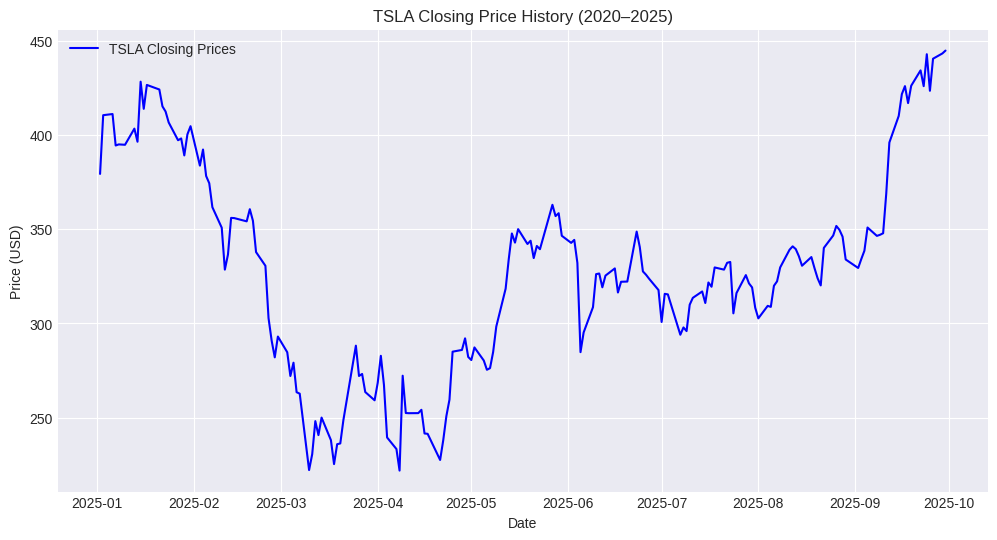

In [144]:
# STEP 4: Data Cleaning and Visualization

# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())

# Delete any rows with missing data
data.dropna(inplace=True)

# Keep only the 'Close' price column for prediction
close_prices = data['Close'].values.reshape(-1, 1)

# Visualize the closing price over time
plt.figure(figsize=(12,6))
plt.plot(data.index, close_prices, label=f"{ticker} Closing Prices", color='blue')
plt.title(f"{ticker} Closing Price History (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [145]:
# STEP 5: Fetch Company News
import requests
import pandas as pd
from datetime import datetime, timedelta
from google.colab import userdata

# Load key from Colab secret storage
NEWS_API_KEY = userdata.get('api_key')   # ← your EODHD API key
NEWS_PROVIDER = "eodhd"                  # default provider you are using


def get_company_news(ticker, start=None, end=None, limit=10, api_key=NEWS_API_KEY):
    """
    Fetch up to `limit` real news headlines for sentiment analysis.
    Default provider = EODHD.
    Returns DataFrame: ['date', 'title']
    """
    headers = {"User-Agent": "market-forecast/1.0"}
    df = pd.DataFrame(columns=["date", "title"])

    # ---------------------------------------------------------
    # 1) FINNHUB (OPTIONAL)
    # ---------------------------------------------------------
    if NEWS_PROVIDER.lower() == "finnhub":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for Finnhub")

        if start is None:
            start = (datetime.utcnow() - timedelta(days=30)).strftime("%Y-%m-%d")
        if end is None:
            end = datetime.utcnow().strftime("%Y-%m-%d")

        url = "https://finnhub.io/api/v1/company-news"
        params = {"symbol": ticker, "from": start, "to": end, "token": api_key}

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list) and len(data) > 0:
                data = data[:limit]
                df = pd.DataFrame([
                    {
                        "date": datetime.utcfromtimestamp(item["datetime"]).strftime("%Y-%m-%d")
                                if item.get("datetime") else "",
                        "title": item.get("headline") or item.get("summary") or ""
                    }
                    for item in data
                ])
        except Exception as e:
            print("Finnhub news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 2) NEWSAPI (OPTIONAL)
    # ---------------------------------------------------------
    elif NEWS_PROVIDER.lower() == "newsapi":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for NewsAPI")

        url = "https://newsapi.org/v2/everything"
        params = {
            "q": ticker,
            "pageSize": limit,
            "language": "en",
            "sortBy": "publishedAt",
            "apiKey": api_key
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            articles = r.json().get("articles", [])

            df = pd.DataFrame([
                {
                    "date": a.get("publishedAt", "")[:10],
                    "title": a.get("title", "")
                }
                for a in articles
            ])
        except Exception as e:
            print("NewsAPI fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 3) EODHD (DEFAULT)
    # ---------------------------------------------------------
    else:
        if not api_key:
            print("⚠️ No EODHD API key found. Using demo key (limited).")
            api_key = "demo"

        url = "https://eodhd.com/api/news"
        params = {
            "s": f"{ticker}.US",
            "limit": limit,
            "api_token": api_key,
            "fmt": "json"
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list):
                df = pd.DataFrame([
                    {
                        "date": item.get("date", "")[:10],
                        "title": item.get("title", "")
                    }
                    for item in data
                ])
        except Exception as e:
            print("EODHD news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # Final cleanup
    # ---------------------------------------------------------
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        df = df.dropna(subset=["date"]).reset_index(drop=True)

    return df


news_df = get_company_news("AAPL", limit=10)
news_df

,date,title
0,2025-11-14,Stocks Retreat as Fed Rate-Cut Chances Fade
1,2025-11-14,"Saudi wealth fund PIF slashes Q3 stakes, keeps..."
2,2025-11-14,AI Voice Assistants Are Making Themselves Hear...
3,2025-11-14,JPMorgan Says Michael Burry Is Dead Wrong Abou...
4,2025-11-14,Classic TV Auction Pulls In $3.17 Million As B...
5,2025-11-14,Apple Sees 22% Jump in China iPhone Sales Afte...
6,2025-11-14,A Bitget ocupa o 2º lugar global em entradas m...
7,2025-11-14,"Do you think gold prices will hit $5,000 next ..."
8,2025-11-14,BC-Most Active Stocks
9,2025-11-14,Apple Stock Resists Tech Selloff. There’s Good...


In [146]:
# STEP 6: Sentiment Analysis of News Headlines

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Ensure lexicon downloaded
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

news_df['sentiment'] = news_df['title'].apply(
    lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else 0
)

# Preview sentiment-scored headlines
sample = news_df[['title', 'sentiment']].head(10)
print(sample)

                                               title  sentiment
0        Stocks Retreat as Fed Rate-Cut Chances Fade     0.3818
1  Saudi wealth fund PIF slashes Q3 stakes, keeps...     0.3400
2  AI Voice Assistants Are Making Themselves Hear...     0.0000
3  JPMorgan Says Michael Burry Is Dead Wrong Abou...    -0.8126
4  Classic TV Auction Pulls In $3.17 Million As B...     0.6369
5  Apple Sees 22% Jump in China iPhone Sales Afte...     0.0000
6  A Bitget ocupa o 2º lugar global em entradas m...     0.0000
7  Do you think gold prices will hit $5,000 next ...     0.0000
8                              BC-Most Active Stocks     0.4019
9  Apple Stock Resists Tech Selloff. There’s Good...     0.4404


In [147]:
# STEP 8: Prepare Multi-Feature Data for LSTM

# Start fresh from price data but merge sentiment from earlier
data_multi = data.copy().reset_index()
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Convert 'date' column in daily_sentiment to datetime for consistent merging
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Merge sentiment data (daily_sentiment) into the price data
data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
if 'date' in data_multi.columns:
    data_multi.drop(columns=['date'], inplace=True)
data_multi['sentiment'] = data_multi['sentiment'].fillna(0)


# Create additional features
data_multi['MA7'] = data_multi['Close'].rolling(window=7).mean()      # 7-day Moving Average
data_multi['MA30'] = data_multi['Close'].rolling(window=30).mean()    # 30-day Moving Average
data_multi['Daily_Return'] = data_multi['Close'].pct_change()         # Daily % change

# Drop any rows with missing values due to rolling calculations
data_multi.dropna(inplace=True)

# Flatten column names if needed (yfinance often adds multi-level columns)
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Select features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment']
print(f"Features used: {features} \n")

# Prepare the feature matrix
multi_data = data_multi[features].values

# Scale all features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler.fit_transform(multi_data)

# Create time-series sequences
time_step = 30  # using 30-day windows
X, y = [], []
for i in range(time_step, len(scaled_multi)):
    X.append(scaled_multi[i-time_step:i])  # past 30 days of all features
    y.append(scaled_multi[i, 0])           # target = next day's Close price

X, y = np.array(X), np.array(y)
print("New input shape (X):", X.shape)
print("New target shape (y):", y.shape)
print()

# Split into training & testing sets again
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Features used: ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment'] 

New input shape (X): (127, 30, 9)
New target shape (y): (127,)

Training set: (101, 30, 9) (101,)
Testing set: (26, 30, 9) (26,)


In [148]:
# STEP 9: Build and Train LSTM Model
import tensorflow as tf

# Callbacks for better training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    verbose=1
)

# Enhanced LSTM model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Model summary
model.summary()

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 0.0666 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0377 - val_loss: 0.1515 - learning_rate: 0.0010
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0235 - val_loss: 0.1390 - learning_rate: 0.0010
Epoch 4/40
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0159
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0150 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0191 - val_loss: 0.0493 - learning_rate: 5.0000e-04
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0159 - val_loss: 0.0855 - learning_rate: 5.0000e-04


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 96)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,581 (1.01 MB)

 Trainable params: 88,193 (344.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 176,388 (689.02 KB)

In [149]:
# STEP 7: Aggregate Daily Sentiment

# Aggregate news sentiment by date for merging with price data
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
print("Daily Sentiment Aggregated:")
print(daily_sentiment.head())

Daily Sentiment Aggregated:
         date  sentiment
0  2025-11-14    0.13884


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

Sample of Actual vs Predicted Prices with Dates:

         Date  Actual Price  Predicted Price
16 2025-09-17    425.859985       385.330123
17 2025-09-18    416.850006       388.745641
18 2025-09-19    426.070007       392.430003
19 2025-09-22    434.209991       396.313033
20 2025-09-23    425.850006       400.272696
21 2025-09-24    442.790009       404.115424
22 2025-09-25    423.390015       407.878092
23 2025-09-26    440.399994       411.395999
24 2025-09-29    443.209991       414.710044
25 2025-09-30    444.720001       417.923135


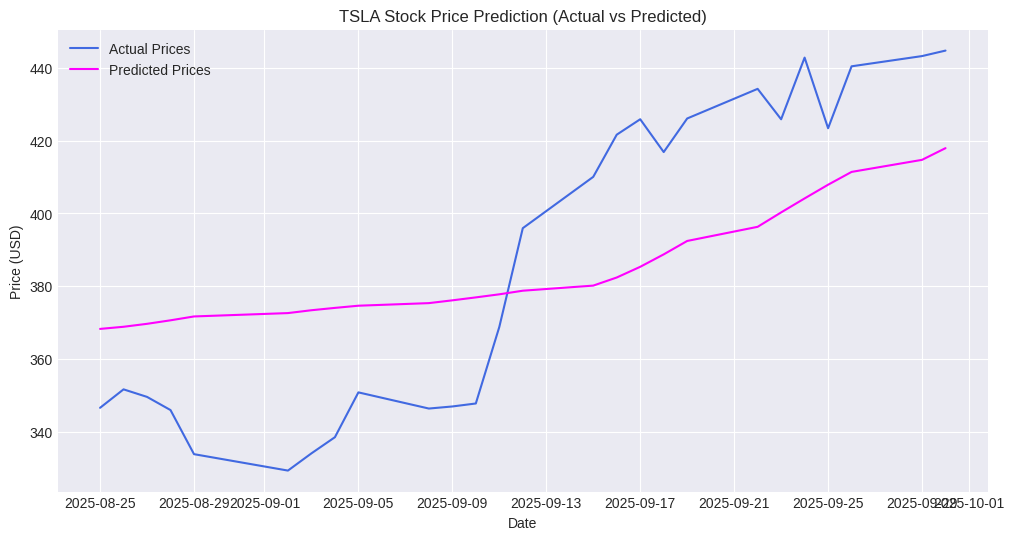


Mean Squared Error (MSE): 906.0618385321874


In [150]:
# STEP 9: Model Prediction and Visualization

# Predict stock prices using the trained model
predictions = model.predict(X_test)

# Convert scaled predictions back to original 'Close' prices
# Get the scaler parameters used for the 'Close' feature (first column)
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Undo scaling manually for Close price
predictions_unscaled = predictions * (close_max - close_min) + close_min
y_test_actual_unscaled = y_test * (close_max - close_min) + close_min

# Attach Dates to Predictions (for readability)
pred_dates = data.index[-len(y_test_actual_unscaled):]

# Create DataFrame for inspection
result_df = pd.DataFrame({
    'Date': pred_dates,
    'Actual Price': y_test_actual_unscaled.flatten(),
    'Predicted Price': predictions_unscaled.flatten()
})

print("\nSample of Actual vs Predicted Prices with Dates:\n")
print(result_df.tail(10))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(result_df['Date'], result_df['Actual Price'], label="Actual Prices", color='royalblue')
plt.plot(result_df['Date'], result_df['Predicted Price'], label="Predicted Prices", color='magenta')
plt.title(f"{ticker} Stock Price Prediction (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate and print Mean Squared Error using unscaled values
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
print("\nMean Squared Error (MSE):", mse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

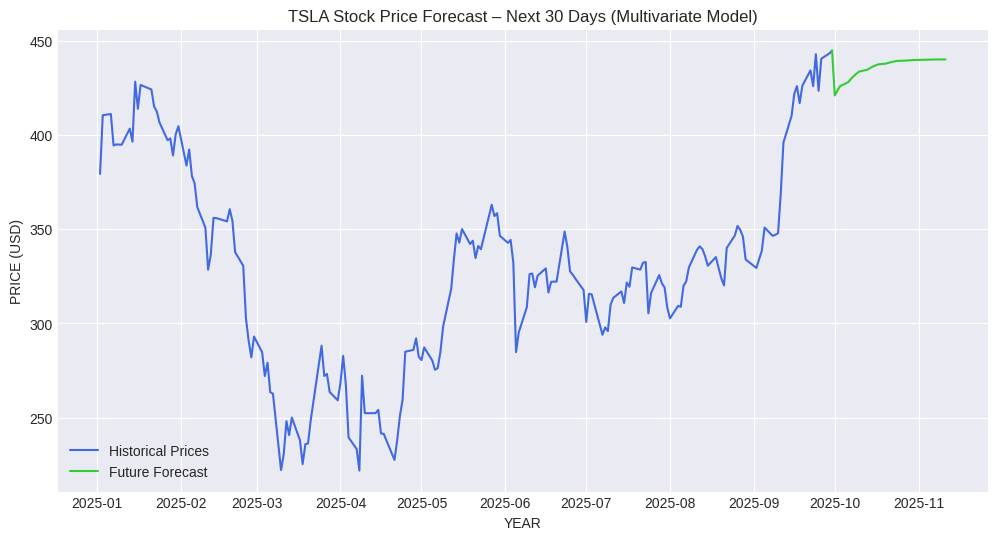

In [151]:
# STEP 11: Future Forecasting Beyond the Dataset

future_days = 30  # For longer forecast

# Take the last 30 days of all 9 features (correcting from 8)
last_30_days = scaled_multi[-30:, :]
future_input = last_30_days.reshape(1, 30, last_30_days.shape[1]).copy() # Use shape[1] to dynamically get the number of features

future_predictions = []

for _ in range(future_days):
    # Predict only the next day's 'Close' (first feature)
    next_close_scaled = model.predict(future_input)[0][0]
    future_predictions.append(next_close_scaled)

    # Create the next input window:
    # start with previous sequence, drop first row
    next_sequence = future_input[:, 1:, :].copy()

    # For the new day:
    # keep other feature values same as last day
    new_day = future_input[:, -1, :].copy()
    new_day[0][0] = next_close_scaled  # replace Close value with predicted one

    # Append new day to the end
    next_sequence = np.append(next_sequence, new_day.reshape(1, 1, last_30_days.shape[1]), axis=1) # Use shape[1]
    future_input = next_sequence

# Convert only the Close predictions back to original scale
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]
future_predictions_unscaled = np.array(future_predictions) * (close_max - close_min) + close_min

# Create future business-day dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                             periods=future_days, freq='B')

# Combine into a DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions_unscaled.flatten()
})

print("\nPredicted Future Prices:\n")
print(future_df)

# To make sure there is no gap between historical and forecast lines
last_actual_price = data['Close'].iloc[-1]
last_actual_date = data.index[-1]

# Insert the last known point at the start of the future forecast
future_df = pd.concat([
    pd.DataFrame({'Date': [last_actual_date], 'Predicted Price': [last_actual_price]}),
    future_df
], ignore_index=True)


# Plot historical + future forecast
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='royalblue')
plt.plot(future_df['Date'], future_df['Predicted Price'],
         label="Future Forecast", color='limegreen')
plt.title(f"{ticker} Stock Price Forecast – Next {future_days} Days (Multivariate Model)")
plt.xlabel("YEAR")
plt.ylabel("PRICE (USD)")
plt.legend()
plt.show()

In [152]:
# --- Recompute sentiment properly so sentiment_score exists ---

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Ensure the news DataFrame has sentiment processed
if 'sentiment' not in news_df.columns:
    news_df['sentiment'] = news_df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Compute overall sentiment score (mean of compound scores)
sentiment_score = news_df['sentiment'].mean()

print("Sentiment Score Computed:", sentiment_score)
print(news_df[['title', 'sentiment']].head(10))


Sentiment Score Computed: 0.13884
                                               title  sentiment
0        Stocks Retreat as Fed Rate-Cut Chances Fade     0.3818
1  Saudi wealth fund PIF slashes Q3 stakes, keeps...     0.3400
2  AI Voice Assistants Are Making Themselves Hear...     0.0000
3  JPMorgan Says Michael Burry Is Dead Wrong Abou...    -0.8126
4  Classic TV Auction Pulls In $3.17 Million As B...     0.6369
5  Apple Sees 22% Jump in China iPhone Sales Afte...     0.0000
6  A Bitget ocupa o 2º lugar global em entradas m...     0.0000
7  Do you think gold prices will hit $5,000 next ...     0.0000
8                              BC-Most Active Stocks     0.4019
9  Apple Stock Resists Tech Selloff. There’s Good...     0.4404


In [153]:
# STEP 10: Generate Market Intelligence Summary

def generate_summary(ticker, df, sentiment_score):
    # Convert Series → float using .item()
    latest_close = df['Close'].iloc[-1].item()
    week_change = ((df['Close'].iloc[-1].item() - df['Close'].iloc[-5].item()) / df['Close'].iloc[-5].item()) * 100

    print("\n===== ✔∇✔ Market Intelligence Summary =====\n")
    print(f"Stock Ticker: {ticker}")
    print(f"Latest Close Price: ${latest_close:.2f}")
    print(f"7-Day Price Change: {week_change:.2f}%")

    print("\nℹ∇ℹ Sentiment Analysis:")
    if sentiment_score > 0.05:
        print(f"Overall Market Sentiment: Bullish (Score: {sentiment_score:.3f})")
    elif sentiment_score < -0.05:
        print(f"Overall Market Sentiment: Bearish (Score: {sentiment_score:.3f})")
    else:
        print(f"Overall Market Sentiment: Neutral (Score: {sentiment_score:.3f})")

    print("\n↗∇↗ LSTM Forecast:")
    print("Prediction for the next trading day has been generated above.")

    print("\n=========================================\n")

# Call summary
generate_summary(ticker, data, sentiment_score)


===== ✔∇✔ Market Intelligence Summary =====

Stock Ticker: TSLA
Latest Close Price: $444.72
7-Day Price Change: 0.44%

ℹ∇ℹ Sentiment Analysis:
Overall Market Sentiment: Bullish (Score: 0.139)

↗∇↗ LSTM Forecast:
Prediction for the next trading day has been generated above.




In [154]:
whos


Variable                      Type                          Data/Info
---------------------------------------------------------------------
Dense                         type                          <class 'keras.src.layers.core.dense.Dense'>
Dropout                       type                          <class 'keras.src.layers.<...>ization.dropout.Dropout'>
LSTM                          type                          <class 'keras.src.layers.rnn.lstm.LSTM'>
MinMaxScaler                  type                          <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
NEWS_API_KEY                  str                           6917447ac43e33.41642983
NEWS_PROVIDER                 str                           eodhd
SentimentIntensityAnalyzer    type                          <class 'nltk.sentiment.va<...>timentIntensityAnalyzer'>
Sequential                    type                          <class 'keras.src.models.sequential.Sequential'>
TextBlob                      type              


--- Investment Advice ---
Predicted change over next 31 days: -1.05%

Model Suggests: 
 Stable trend – Market appears steady. Consider HOLDING your position. 

R² Score: 0.49792619199029053

Report generated on: 2025-11-14 12:24 PM 



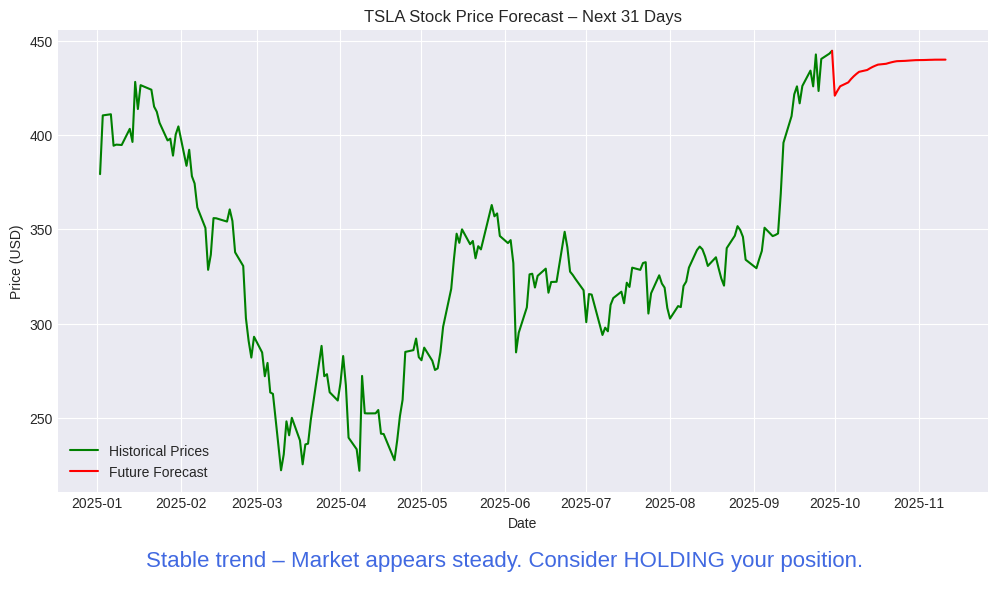

<Figure size 640x480 with 0 Axes>

In [155]:
# STEP 12: Investment Advice Based on Predicted Trend
import datetime
local_time = datetime.datetime.now(toronto_tz)

# Working with scalar (not Series) values
start_price = float(future_df['Predicted Price'].iloc[0])
end_price = float(future_df['Predicted Price'].iloc[-1])

# Calculate percent change between first and last predicted price
percent_change = ((end_price - start_price) / start_price) * 100

# Decide recommendation (right time to invest in it or not)
if percent_change > 2:
    advice = "STRONG UPTREND DETECTED !! – It may be a good time to INVEST (BUY). \n"
elif percent_change < -2:
    advice = "DOWNTREND DETECTED – Avoid investing right now or consider SELLING. \n"
else:
    advice = "Stable trend – Market appears steady. Consider HOLDING your position. \n"

print("\n--- Investment Advice ---")
print(f"Predicted change over next {len(future_df)} days: {percent_change:.2f}%")
print()
print("Model Suggests: \n", advice)


r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)
print("R² Score:", r2)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='green')

print()

# Set timezone to Toronto (Eastern Time)
toronto_tz = pytz.timezone('America/Toronto')

# Get current local time in Toronto
local_time = datetime.datetime.now(toronto_tz)

print("Report generated on:", local_time.strftime("%Y-%m-%d %I:%M %p \n"))

plt.plot(future_df['Date'], future_df['Predicted Price'], label="Future Forecast", color='red')
plt.title(f"{ticker} Stock Price Forecast – Next {len(future_df)} Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.figtext(0.5, -0.05, advice, wrap=True, ha='center', fontsize=16, color='royalblue')
plt.show()
plt.savefig("MSFT_Forecast_Results.png", dpi=300, bbox_inches='tight') # to save the final figure

In [156]:
# STEP 13: Model Performance Summary
# 13.1 Accuracy of the model: show how closely predicted prices match real prices.

# Calculate metrics
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_actual_unscaled, predictions_unscaled)
r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)

# Display results neatly
print("\n        MODEL PERFORMANCE SUMMARY \n")
print(f"Mean Squared Error (MSE):      {mse:.6f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f} USD")
print(f"R² Score (Model Fit):          {r2:.4f}")
print()

# 13.2 single RNN Model trained using LSTM layers

total_layers = len(model.layers)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Number of layers in this single model: {total_layers}")
print(f"Total trainable parameters: {trainable_params:,}")
print()

# Brief interpretation for output readability
if r2 > 0.9:
    print("\u2705 Excellent model fit! Predictions closely follow actual prices.")
elif r2 > 0.75:
    print("\u2705 Good model fit. Model captures major trends well.")
else:
    print("\u26a0∇ Model could be improved with more epochs, features, or tuning.")


        MODEL PERFORMANCE SUMMARY 

Mean Squared Error (MSE):      906.061839
Mean Absolute Error (MAE):     28.8471 USD
R² Score (Model Fit):          0.4979

Number of layers in this single model: 7
Total trainable parameters: 88,193

⚠∇ Model could be improved with more epochs, features, or tuning.
